In [7]:
# Cell 1: Mount Google Drive and Setup
from google.colab import drive
drive.mount('/content/drive')

PROJECT_DIR = "/content/drive/MyDrive/CodeSearchNet_Project"
import os
os.makedirs(PROJECT_DIR, exist_ok=True)
os.chdir(PROJECT_DIR)

print(f"Working directory: {os.getcwd()}")
print(f"Files in directory: {os.listdir(PROJECT_DIR)}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Working directory: /content/drive/MyDrive/CodeSearchNet_Project
Files in directory: ['src_vocab.pkl', 'tgt_vocab.pkl']


In [8]:
!pip install -q datasets torch torchtext matplotlib seaborn nltk sacrebleu

In [9]:
# Cell 3: Imports and Setup
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
import time
from tqdm import tqdm
import pickle

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory Available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


Using device: cuda
GPU: Tesla T4
Memory Available: 15.83 GB


In [10]:
# Cell 4: Load and Preprocess Data
print("Loading dataset...")
dataset = load_dataset("Nan-Do/code-search-net-python")

print("Available splits:", dataset.keys())

# Configuration
MAX_DOCSTRING_LENGTH = 50
MAX_CODE_LENGTH = 80
NUM_TRAIN_SAMPLES = 10000
NUM_VAL_SAMPLES = 1000
NUM_TEST_SAMPLES = 1000

class Vocabulary:
    def __init__(self):
        self.word2idx = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3}
        self.idx2word = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>'}
        self.word_count = {}
        self.n_words = 4

    def add_sentence(self, sentence):
        for word in sentence.split():
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.n_words
            self.idx2word[self.n_words] = word
            self.word_count[word] = 1
            self.n_words += 1
        else:
            self.word_count[word] += 1

    def sentence_to_indices(self, sentence, max_length):
        indices = [self.word2idx.get(word, self.word2idx['<UNK>'])
                   for word in sentence.split()[:max_length]]
        indices = [self.word2idx['<SOS>']] + indices + [self.word2idx['<EOS>']]
        return indices

    def indices_to_sentence(self, indices):
        return ' '.join([self.idx2word[idx] for idx in indices
                        if idx not in [self.word2idx['<PAD>'],
                                      self.word2idx['<SOS>'],
                                      self.word2idx['<EOS>']]])

def preprocess_data(dataset_split, num_samples):
    """Filter and preprocess dataset"""
    data = []
    count = 0

    for example in dataset_split:
        if count >= num_samples:
            break

        try:
            # Get docstring
            if 'docstring_tokens' in example and example['docstring_tokens']:
                docstring = ' '.join(example['docstring_tokens'])
            elif 'docstring' in example and example['docstring']:
                docstring = example['docstring']
            elif 'summary' in example and example['summary']:
                docstring = example['summary']
            else:
                continue

            # Get code
            if 'code_tokens' in example and example['code_tokens']:
                code = ' '.join(example['code_tokens'])
            elif 'code' in example and example['code']:
                code = example['code']
            else:
                continue

            if docstring and code:
                doc_tokens = str(docstring).strip().split()
                code_tokens = str(code).strip().split()

                if (len(doc_tokens) > 0 and len(doc_tokens) <= MAX_DOCSTRING_LENGTH and
                    len(code_tokens) > 0 and len(code_tokens) <= MAX_CODE_LENGTH):
                    data.append({
                        'docstring': ' '.join(doc_tokens),
                        'code': ' '.join(code_tokens)
                    })
                    count += 1
        except Exception as e:
            continue

    return data

# Preprocess data
print("Preprocessing data...")
total_samples_needed = NUM_TRAIN_SAMPLES + NUM_VAL_SAMPLES + NUM_TEST_SAMPLES
all_data = preprocess_data(dataset['train'], total_samples_needed)

print(f"Total samples collected: {len(all_data)}")

# Split data
train_data = all_data[:NUM_TRAIN_SAMPLES]
val_data = all_data[NUM_TRAIN_SAMPLES:NUM_TRAIN_SAMPLES + NUM_VAL_SAMPLES]
test_data = all_data[NUM_TRAIN_SAMPLES + NUM_VAL_SAMPLES:NUM_TRAIN_SAMPLES + NUM_VAL_SAMPLES + NUM_TEST_SAMPLES]

print(f"\nTrain samples: {len(train_data)}")
print(f"Val samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")

if len(train_data) > 0:
    print(f"\nSample example:")
    print(f"Docstring: {train_data[0]['docstring'][:150]}...")
    print(f"Code: {train_data[0]['code'][:150]}...")

# Build vocabularies
print("\nBuilding vocabularies...")
src_vocab = Vocabulary()
tgt_vocab = Vocabulary()

for pair in train_data:
    src_vocab.add_sentence(pair['docstring'])
    tgt_vocab.add_sentence(pair['code'])

print(f"Source vocab size: {src_vocab.n_words}")
print(f"Target vocab size: {tgt_vocab.n_words}")

# Save vocabularies to Google Drive
with open(os.path.join(PROJECT_DIR, 'src_vocab.pkl'), 'wb') as f:
    pickle.dump(src_vocab, f)
with open(os.path.join(PROJECT_DIR, 'tgt_vocab.pkl'), 'wb') as f:
    pickle.dump(tgt_vocab, f)

# Save data splits
with open(os.path.join(PROJECT_DIR, 'train_data.pkl'), 'wb') as f:
    pickle.dump(train_data, f)
with open(os.path.join(PROJECT_DIR, 'val_data.pkl'), 'wb') as f:
    pickle.dump(val_data, f)
with open(os.path.join(PROJECT_DIR, 'test_data.pkl'), 'wb') as f:
    pickle.dump(test_data, f)

print("\nData preprocessing complete and saved to Google Drive!")


Loading dataset...
Available splits: dict_keys(['train'])
Preprocessing data...
Total samples collected: 12000

Train samples: 10000
Val samples: 1000
Test samples: 1000

Sample example:
Docstring: Convert a dlib rect object to a plain tuple in ( top right bottom left ) order...
Code: def _rect_to_css ( rect ) : return rect . top ( ) , rect . right ( ) , rect . bottom ( ) , rect . left ( )...

Building vocabularies...
Source vocab size: 9840
Target vocab size: 36163

Data preprocessing complete and saved to Google Drive!


In [11]:
# Cell 5: Dataset and DataLoader
class CodeGenerationDataset(Dataset):
    def __init__(self, data, src_vocab, tgt_vocab):
        self.data = data
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pair = self.data[idx]
        src_indices = self.src_vocab.sentence_to_indices(
            pair['docstring'], MAX_DOCSTRING_LENGTH)
        tgt_indices = self.tgt_vocab.sentence_to_indices(
            pair['code'], MAX_CODE_LENGTH)
        return torch.tensor(src_indices), torch.tensor(tgt_indices)

def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)

    src_lengths = [len(s) for s in src_batch]
    tgt_lengths = [len(t) for t in tgt_batch]

    max_src_len = max(src_lengths)
    max_tgt_len = max(tgt_lengths)

    src_padded = torch.zeros(len(batch), max_src_len, dtype=torch.long)
    tgt_padded = torch.zeros(len(batch), max_tgt_len, dtype=torch.long)

    for i, (src, tgt) in enumerate(zip(src_batch, tgt_batch)):
        src_padded[i, :len(src)] = src
        tgt_padded[i, :len(tgt)] = tgt

    return src_padded, tgt_padded, torch.tensor(src_lengths), torch.tensor(tgt_lengths)

# Create datasets
train_dataset = CodeGenerationDataset(train_data, src_vocab, tgt_vocab)
val_dataset = CodeGenerationDataset(val_data, src_vocab, tgt_vocab)
test_dataset = CodeGenerationDataset(test_data, src_vocab, tgt_vocab)

# Create dataloaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(f"DataLoaders created!")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


DataLoaders created!
Train batches: 313
Val batches: 32
Test batches: 32


In [12]:
# Cell 6: Model Architectures
# Model 1: Vanilla RNN
class EncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_dim):
        super(EncoderRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(input_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)

    def forward(self, src, src_lengths):
        embedded = self.embedding(src)
        outputs, hidden = self.rnn(embedded)
        return outputs, hidden

class DecoderRNN(nn.Module):
    def __init__(self, output_size, embedding_dim, hidden_dim):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.out = nn.Linear(hidden_dim, output_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input)
        output, hidden = self.rnn(embedded, hidden)
        prediction = self.out(output)
        return prediction, hidden

class Seq2SeqRNN(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2SeqRNN, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, tgt, src_lengths, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        tgt_len = tgt.shape[1]
        tgt_vocab_size = self.decoder.out.out_features

        outputs = torch.zeros(batch_size, tgt_len, tgt_vocab_size).to(self.device)

        encoder_outputs, hidden = self.encoder(src, src_lengths)

        input = tgt[:, 0].unsqueeze(1)

        for t in range(1, tgt_len):
            output, hidden = self.decoder(input, hidden)
            outputs[:, t, :] = output.squeeze(1)

            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(2)
            input = tgt[:, t].unsqueeze(1) if teacher_force else top1

        return outputs

# Model 2: LSTM
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_dim):
        super(EncoderLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(input_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

    def forward(self, src, src_lengths):
        embedded = self.embedding(src)
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, hidden, cell

class DecoderLSTM(nn.Module):
    def __init__(self, output_size, embedding_dim, hidden_dim):
        super(DecoderLSTM, self).__init__()
        self.embedding = nn.Embedding(output_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.out = nn.Linear(hidden_dim, output_size)

    def forward(self, input, hidden, cell):
        embedded = self.embedding(input)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.out(output)
        return prediction, hidden, cell

class Seq2SeqLSTM(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2SeqLSTM, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, tgt, src_lengths, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        tgt_len = tgt.shape[1]
        tgt_vocab_size = self.decoder.out.out_features

        outputs = torch.zeros(batch_size, tgt_len, tgt_vocab_size).to(self.device)

        encoder_outputs, hidden, cell = self.encoder(src, src_lengths)

        input = tgt[:, 0].unsqueeze(1)

        for t in range(1, tgt_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[:, t, :] = output.squeeze(1)

            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(2)
            input = tgt[:, t].unsqueeze(1) if teacher_force else top1

        return outputs

# Model 3: LSTM with Attention (FIXED)
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_dim * 2, hidden_dim * 2)
        self.Ua = nn.Linear(hidden_dim * 2, hidden_dim * 2)
        self.Va = nn.Linear(hidden_dim * 2, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query).unsqueeze(1) + self.Ua(keys)))
        scores = scores.squeeze(2)

        attention_weights = torch.softmax(scores, dim=1)

        context = torch.bmm(attention_weights.unsqueeze(1), keys)
        context = context.squeeze(1)

        return context, attention_weights

class EncoderLSTMBidirectional(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_dim):
        super(EncoderLSTMBidirectional, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(input_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)

    def forward(self, src, src_lengths):
        embedded = self.embedding(src)
        outputs, (hidden, cell) = self.lstm(embedded)

        # Concatenate forward and backward states
        hidden = torch.cat([hidden[-2], hidden[-1]], dim=1).unsqueeze(0)
        cell = torch.cat([cell[-2], cell[-1]], dim=1).unsqueeze(0)

        return outputs, hidden, cell

class DecoderLSTMAttention(nn.Module):
    def __init__(self, output_size, embedding_dim, hidden_dim, attention):
        super(DecoderLSTMAttention, self).__init__()
        self.embedding = nn.Embedding(output_size, embedding_dim, padding_idx=0)
        self.attention = attention
        self.lstm = nn.LSTM(embedding_dim + hidden_dim * 2, hidden_dim * 2, batch_first=True)
        self.out = nn.Linear(hidden_dim * 2, output_size)

    def forward(self, input, hidden, cell, encoder_outputs):
        embedded = self.embedding(input)

        context, attention_weights = self.attention(hidden.squeeze(0), encoder_outputs)

        lstm_input = torch.cat([embedded, context.unsqueeze(1)], dim=2)

        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))

        prediction = self.out(output)

        return prediction, hidden, cell, attention_weights

class Seq2SeqLSTMAttention(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2SeqLSTMAttention, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, tgt, src_lengths, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        tgt_len = tgt.shape[1]
        tgt_vocab_size = self.decoder.out.out_features

        outputs = torch.zeros(batch_size, tgt_len, tgt_vocab_size).to(self.device)
        attentions = torch.zeros(batch_size, tgt_len, src.shape[1]).to(self.device)

        encoder_outputs, hidden, cell = self.encoder(src, src_lengths)

        input = tgt[:, 0].unsqueeze(1)

        for t in range(1, tgt_len):
            output, hidden, cell, attention_weights = self.decoder(
                input, hidden, cell, encoder_outputs)
            outputs[:, t, :] = output.squeeze(1)
            attentions[:, t, :] = attention_weights

            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(2)
            input = tgt[:, t].unsqueeze(1) if teacher_force else top1

        return outputs, attentions

print("All model architectures defined!")


All model architectures defined!


In [13]:
# Cell 7: Training Functions
def train_epoch(model, iterator, optimizer, criterion, clip, model_type='rnn'):
    model.train()
    epoch_loss = 0

    for src, tgt, src_lengths, tgt_lengths in tqdm(iterator, desc="Training"):
        src, tgt = src.to(device), tgt.to(device)

        optimizer.zero_grad()

        if model_type == 'attention':
            output, _ = model(src, tgt, src_lengths, teacher_forcing_ratio=0.5)
        else:
            output = model(src, tgt, src_lengths, teacher_forcing_ratio=0.5)

        output = output[:, 1:].reshape(-1, output.shape[-1])
        tgt = tgt[:, 1:].reshape(-1)

        loss = criterion(output, tgt)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion, model_type='rnn'):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for src, tgt, src_lengths, tgt_lengths in iterator:
            src, tgt = src.to(device), tgt.to(device)

            if model_type == 'attention':
                output, _ = model(src, tgt, src_lengths, teacher_forcing_ratio=0)
            else:
                output = model(src, tgt, src_lengths, teacher_forcing_ratio=0)

            output = output[:, 1:].reshape(-1, output.shape[-1])
            tgt = tgt[:, 1:].reshape(-1)

            loss = criterion(output, tgt)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def train_model(model, train_loader, val_loader, optimizer, criterion,
                n_epochs, model_name, model_type='rnn'):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        start_time = time.time()

        train_loss = train_epoch(model, train_loader, optimizer, criterion, 1, model_type)
        val_loss = evaluate(model, val_loader, criterion, model_type)

        end_time = time.time()
        epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # Save to Google Drive
            torch.save(model.state_dict(), os.path.join(PROJECT_DIR, f'{model_name}_best.pt'))

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins:.0f}m {epoch_secs:.0f}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f}')

    # Save loss history
    with open(os.path.join(PROJECT_DIR, f'{model_name}_losses.pkl'), 'wb') as f:
        pickle.dump({'train': train_losses, 'val': val_losses}, f)

    return train_losses, val_losses

print("Training functions defined!")


Training functions defined!


In [14]:
# Cell 8: Train All Models
EMBEDDING_DIM = 256
HIDDEN_DIM = 256
N_EPOCHS = 20
LEARNING_RATE = 0.001

INPUT_DIM = src_vocab.n_words
OUTPUT_DIM = tgt_vocab.n_words

criterion = nn.CrossEntropyLoss(ignore_index=0)

# Model 1: Vanilla RNN
print("\n" + "="*50)
print("Training Vanilla RNN Seq2Seq")
print("="*50)

enc_rnn = EncoderRNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM).to(device)
dec_rnn = DecoderRNN(OUTPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM).to(device)
model_rnn = Seq2SeqRNN(enc_rnn, dec_rnn, device).to(device)

optimizer_rnn = optim.Adam(model_rnn.parameters(), lr=LEARNING_RATE)
train_losses_rnn, val_losses_rnn = train_model(
    model_rnn, train_loader, val_loader, optimizer_rnn, criterion,
    N_EPOCHS, 'vanilla_rnn', 'rnn')

# Model 2: LSTM
print("\n" + "="*50)
print("Training LSTM Seq2Seq")
print("="*50)

enc_lstm = EncoderLSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM).to(device)
dec_lstm = DecoderLSTM(OUTPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM).to(device)
model_lstm = Seq2SeqLSTM(enc_lstm, dec_lstm, device).to(device)

optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=LEARNING_RATE)
train_losses_lstm, val_losses_lstm = train_model(
    model_lstm, train_loader, val_loader, optimizer_lstm, criterion,
    N_EPOCHS, 'lstm', 'lstm')

# Model 3: LSTM with Attention
print("\n" + "="*50)
print("Training LSTM with Attention")
print("="*50)

enc_lstm_bi = EncoderLSTMBidirectional(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM).to(device)
attention = BahdanauAttention(HIDDEN_DIM).to(device)
dec_lstm_attn = DecoderLSTMAttention(OUTPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, attention).to(device)
model_attention = Seq2SeqLSTMAttention(enc_lstm_bi, dec_lstm_attn, device).to(device)

optimizer_attention = optim.Adam(model_attention.parameters(), lr=LEARNING_RATE)
train_losses_attn, val_losses_attn = train_model(
    model_attention, train_loader, val_loader, optimizer_attention, criterion,
    N_EPOCHS, 'lstm_attention', 'attention')

print("\n" + "="*50)
print("ALL MODELS TRAINED AND SAVED TO GOOGLE DRIVE!")
print("="*50)



Training Vanilla RNN Seq2Seq


Training: 100%|██████████| 313/313 [03:52<00:00,  1.35it/s]


Epoch: 01 | Time: 4m 2s
	Train Loss: 5.497 | Val Loss: 6.076


Training: 100%|██████████| 313/313 [03:45<00:00,  1.39it/s]


Epoch: 02 | Time: 3m 55s
	Train Loss: 4.781 | Val Loss: 6.413


Training: 100%|██████████| 313/313 [03:44<00:00,  1.39it/s]


Epoch: 03 | Time: 3m 54s
	Train Loss: 4.575 | Val Loss: 6.374


Training: 100%|██████████| 313/313 [03:44<00:00,  1.39it/s]


Epoch: 04 | Time: 3m 55s
	Train Loss: 4.426 | Val Loss: 6.539


Training: 100%|██████████| 313/313 [03:44<00:00,  1.40it/s]


Epoch: 05 | Time: 3m 54s
	Train Loss: 4.317 | Val Loss: 6.476


Training: 100%|██████████| 313/313 [03:45<00:00,  1.39it/s]


Epoch: 06 | Time: 3m 55s
	Train Loss: 4.229 | Val Loss: 6.668


Training: 100%|██████████| 313/313 [03:44<00:00,  1.39it/s]


Epoch: 07 | Time: 3m 55s
	Train Loss: 4.155 | Val Loss: 6.529


Training: 100%|██████████| 313/313 [03:44<00:00,  1.39it/s]


Epoch: 08 | Time: 3m 55s
	Train Loss: 4.099 | Val Loss: 6.744


Training: 100%|██████████| 313/313 [03:44<00:00,  1.39it/s]


Epoch: 09 | Time: 3m 55s
	Train Loss: 4.039 | Val Loss: 6.818


Training: 100%|██████████| 313/313 [03:44<00:00,  1.39it/s]


Epoch: 10 | Time: 3m 54s
	Train Loss: 3.964 | Val Loss: 6.789


Training: 100%|██████████| 313/313 [03:44<00:00,  1.39it/s]


Epoch: 11 | Time: 3m 54s
	Train Loss: 3.895 | Val Loss: 6.751


Training: 100%|██████████| 313/313 [03:45<00:00,  1.39it/s]


Epoch: 12 | Time: 3m 55s
	Train Loss: 3.858 | Val Loss: 8.253


Training: 100%|██████████| 313/313 [03:44<00:00,  1.39it/s]


Epoch: 13 | Time: 3m 54s
	Train Loss: 3.801 | Val Loss: 7.876


Training: 100%|██████████| 313/313 [03:44<00:00,  1.39it/s]


Epoch: 14 | Time: 3m 55s
	Train Loss: 3.784 | Val Loss: 7.209


Training: 100%|██████████| 313/313 [03:44<00:00,  1.39it/s]


Epoch: 15 | Time: 3m 55s
	Train Loss: 3.713 | Val Loss: 7.107


Training: 100%|██████████| 313/313 [03:44<00:00,  1.39it/s]


Epoch: 16 | Time: 3m 54s
	Train Loss: 3.689 | Val Loss: 7.426


Training: 100%|██████████| 313/313 [03:44<00:00,  1.39it/s]


Epoch: 17 | Time: 3m 55s
	Train Loss: 3.659 | Val Loss: 7.154


Training: 100%|██████████| 313/313 [03:45<00:00,  1.39it/s]


Epoch: 18 | Time: 3m 55s
	Train Loss: 3.631 | Val Loss: 8.908


Training: 100%|██████████| 313/313 [03:44<00:00,  1.39it/s]


Epoch: 19 | Time: 3m 55s
	Train Loss: 3.561 | Val Loss: 7.345


Training: 100%|██████████| 313/313 [03:44<00:00,  1.39it/s]


Epoch: 20 | Time: 3m 55s
	Train Loss: 3.538 | Val Loss: 7.317

Training LSTM Seq2Seq


Training: 100%|██████████| 313/313 [03:44<00:00,  1.39it/s]


Epoch: 01 | Time: 3m 55s
	Train Loss: 5.645 | Val Loss: 5.998


Training: 100%|██████████| 313/313 [03:44<00:00,  1.39it/s]


Epoch: 02 | Time: 3m 55s
	Train Loss: 4.837 | Val Loss: 6.271


Training: 100%|██████████| 313/313 [03:43<00:00,  1.40it/s]


Epoch: 03 | Time: 3m 53s
	Train Loss: 4.603 | Val Loss: 6.208


Training: 100%|██████████| 313/313 [03:44<00:00,  1.39it/s]


Epoch: 04 | Time: 3m 54s
	Train Loss: 4.407 | Val Loss: 6.526


Training: 100%|██████████| 313/313 [03:46<00:00,  1.38it/s]


Epoch: 05 | Time: 3m 56s
	Train Loss: 4.261 | Val Loss: 6.594


Training: 100%|██████████| 313/313 [03:46<00:00,  1.38it/s]


Epoch: 06 | Time: 3m 56s
	Train Loss: 4.131 | Val Loss: 6.597


Training: 100%|██████████| 313/313 [03:46<00:00,  1.38it/s]


Epoch: 07 | Time: 3m 57s
	Train Loss: 4.023 | Val Loss: 6.696


Training: 100%|██████████| 313/313 [03:45<00:00,  1.39it/s]


Epoch: 08 | Time: 3m 56s
	Train Loss: 3.927 | Val Loss: 6.777


Training: 100%|██████████| 313/313 [03:45<00:00,  1.39it/s]


Epoch: 09 | Time: 3m 56s
	Train Loss: 3.825 | Val Loss: 6.767


Training: 100%|██████████| 313/313 [03:46<00:00,  1.38it/s]


Epoch: 10 | Time: 3m 57s
	Train Loss: 3.719 | Val Loss: 7.074


Training: 100%|██████████| 313/313 [03:46<00:00,  1.38it/s]


Epoch: 11 | Time: 3m 56s
	Train Loss: 3.636 | Val Loss: 7.047


Training: 100%|██████████| 313/313 [03:47<00:00,  1.38it/s]


Epoch: 12 | Time: 3m 57s
	Train Loss: 3.527 | Val Loss: 7.349


Training: 100%|██████████| 313/313 [03:45<00:00,  1.39it/s]


Epoch: 13 | Time: 3m 55s
	Train Loss: 3.434 | Val Loss: 7.105


Training: 100%|██████████| 313/313 [03:46<00:00,  1.38it/s]


Epoch: 14 | Time: 3m 56s
	Train Loss: 3.353 | Val Loss: 7.316


Training: 100%|██████████| 313/313 [03:46<00:00,  1.38it/s]


Epoch: 15 | Time: 3m 56s
	Train Loss: 3.289 | Val Loss: 7.241


Training: 100%|██████████| 313/313 [03:45<00:00,  1.39it/s]


Epoch: 16 | Time: 3m 56s
	Train Loss: 3.211 | Val Loss: 7.171


Training: 100%|██████████| 313/313 [03:45<00:00,  1.39it/s]


Epoch: 17 | Time: 3m 56s
	Train Loss: 3.123 | Val Loss: 7.189


Training: 100%|██████████| 313/313 [03:46<00:00,  1.38it/s]


Epoch: 18 | Time: 3m 56s
	Train Loss: 3.048 | Val Loss: 7.303


Training: 100%|██████████| 313/313 [03:45<00:00,  1.39it/s]


Epoch: 19 | Time: 3m 55s
	Train Loss: 2.969 | Val Loss: 7.171


Training: 100%|██████████| 313/313 [03:46<00:00,  1.38it/s]


Epoch: 20 | Time: 3m 56s
	Train Loss: 2.881 | Val Loss: 7.387

Training LSTM with Attention


Training: 100%|██████████| 313/313 [04:42<00:00,  1.11it/s]


Epoch: 01 | Time: 4m 54s
	Train Loss: 5.549 | Val Loss: 5.954


Training: 100%|██████████| 313/313 [04:41<00:00,  1.11it/s]


Epoch: 02 | Time: 4m 53s
	Train Loss: 4.765 | Val Loss: 6.081


Training: 100%|██████████| 313/313 [04:42<00:00,  1.11it/s]


Epoch: 03 | Time: 4m 53s
	Train Loss: 4.502 | Val Loss: 6.253


Training: 100%|██████████| 313/313 [04:42<00:00,  1.11it/s]


Epoch: 04 | Time: 4m 53s
	Train Loss: 4.268 | Val Loss: 6.301


Training: 100%|██████████| 313/313 [04:42<00:00,  1.11it/s]


Epoch: 05 | Time: 4m 53s
	Train Loss: 4.042 | Val Loss: 6.435


Training: 100%|██████████| 313/313 [04:41<00:00,  1.11it/s]


Epoch: 06 | Time: 4m 53s
	Train Loss: 3.838 | Val Loss: 6.524


Training: 100%|██████████| 313/313 [04:42<00:00,  1.11it/s]


Epoch: 07 | Time: 4m 53s
	Train Loss: 3.617 | Val Loss: 6.619


Training: 100%|██████████| 313/313 [04:41<00:00,  1.11it/s]


Epoch: 08 | Time: 4m 53s
	Train Loss: 3.392 | Val Loss: 6.740


Training: 100%|██████████| 313/313 [04:41<00:00,  1.11it/s]


Epoch: 09 | Time: 4m 52s
	Train Loss: 3.165 | Val Loss: 6.883


Training: 100%|██████████| 313/313 [04:42<00:00,  1.11it/s]


Epoch: 10 | Time: 4m 53s
	Train Loss: 2.944 | Val Loss: 6.899


Training: 100%|██████████| 313/313 [04:42<00:00,  1.11it/s]


Epoch: 11 | Time: 4m 53s
	Train Loss: 2.704 | Val Loss: 7.025


Training: 100%|██████████| 313/313 [04:42<00:00,  1.11it/s]


Epoch: 12 | Time: 4m 54s
	Train Loss: 2.481 | Val Loss: 7.167


Training: 100%|██████████| 313/313 [04:41<00:00,  1.11it/s]


Epoch: 13 | Time: 4m 53s
	Train Loss: 2.269 | Val Loss: 7.300


Training: 100%|██████████| 313/313 [04:41<00:00,  1.11it/s]


Epoch: 14 | Time: 4m 53s
	Train Loss: 2.063 | Val Loss: 7.495


Training: 100%|██████████| 313/313 [04:42<00:00,  1.11it/s]


Epoch: 15 | Time: 4m 53s
	Train Loss: 1.924 | Val Loss: 7.504


Training: 100%|██████████| 313/313 [04:41<00:00,  1.11it/s]


Epoch: 16 | Time: 4m 53s
	Train Loss: 1.773 | Val Loss: 7.643


Training: 100%|██████████| 313/313 [04:42<00:00,  1.11it/s]


Epoch: 17 | Time: 4m 53s
	Train Loss: 1.677 | Val Loss: 7.721


Training: 100%|██████████| 313/313 [04:41<00:00,  1.11it/s]


Epoch: 18 | Time: 4m 53s
	Train Loss: 1.561 | Val Loss: 7.887


Training: 100%|██████████| 313/313 [04:41<00:00,  1.11it/s]


Epoch: 19 | Time: 4m 53s
	Train Loss: 1.476 | Val Loss: 8.029


Training: 100%|██████████| 313/313 [04:42<00:00,  1.11it/s]


Epoch: 20 | Time: 4m 53s
	Train Loss: 1.386 | Val Loss: 8.093

ALL MODELS TRAINED AND SAVED TO GOOGLE DRIVE!


In [2]:
# Cell 8.5: Install sacrebleu (run this before Cell 9)
!pip install sacrebleu -q
print("sacrebleu installed successfully!")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.8/100.8 kB 7.0 MB/s eta 0:00:00
sacrebleu installed successfully!


In [5]:
# Cell 8.5: Recovery - Reconnect and Load Everything (FIXED)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

PROJECT_DIR = "/content/drive/MyDrive/CodeSearchNet_Project"
import os
os.chdir(PROJECT_DIR)

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle
from tqdm import tqdm

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Configuration
MAX_DOCSTRING_LENGTH = 50
MAX_CODE_LENGTH = 80
EMBEDDING_DIM = 256
HIDDEN_DIM = 256

# IMPORTANT: Define Vocabulary class BEFORE loading pickle files
class Vocabulary:
    def __init__(self):
        self.word2idx = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3}
        self.idx2word = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>'}
        self.word_count = {}
        self.n_words = 4

    def add_sentence(self, sentence):
        for word in sentence.split():
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.n_words
            self.idx2word[self.n_words] = word
            self.word_count[word] = 1
            self.n_words += 1
        else:
            self.word_count[word] += 1

    def sentence_to_indices(self, sentence, max_length):
        indices = [self.word2idx.get(word, self.word2idx['<UNK>'])
                   for word in sentence.split()[:max_length]]
        indices = [self.word2idx['<SOS>']] + indices + [self.word2idx['<EOS>']]
        return indices

    def indices_to_sentence(self, indices):
        return ' '.join([self.idx2word[idx] for idx in indices
                        if idx not in [self.word2idx['<PAD>'],
                                      self.word2idx['<SOS>'],
                                      self.word2idx['<EOS>']]])

# Now load vocabularies
with open(os.path.join(PROJECT_DIR, 'src_vocab.pkl'), 'rb') as f:
    src_vocab = pickle.load(f)
with open(os.path.join(PROJECT_DIR, 'tgt_vocab.pkl'), 'rb') as f:
    tgt_vocab = pickle.load(f)

# Load data splits
with open(os.path.join(PROJECT_DIR, 'train_data.pkl'), 'rb') as f:
    train_data = pickle.load(f)
with open(os.path.join(PROJECT_DIR, 'val_data.pkl'), 'rb') as f:
    val_data = pickle.load(f)
with open(os.path.join(PROJECT_DIR, 'test_data.pkl'), 'rb') as f:
    test_data = pickle.load(f)

print(f"Vocabularies and data loaded!")
print(f"Source vocab size: {src_vocab.n_words}")
print(f"Target vocab size: {tgt_vocab.n_words}")
print(f"Test samples: {len(test_data)}")

INPUT_DIM = src_vocab.n_words
OUTPUT_DIM = tgt_vocab.n_words

# Redefine all model classes
# Model 1: Vanilla RNN
class EncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_dim):
        super(EncoderRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(input_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)

    def forward(self, src, src_lengths):
        embedded = self.embedding(src)
        outputs, hidden = self.rnn(embedded)
        return outputs, hidden

class DecoderRNN(nn.Module):
    def __init__(self, output_size, embedding_dim, hidden_dim):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.out = nn.Linear(hidden_dim, output_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input)
        output, hidden = self.rnn(embedded, hidden)
        prediction = self.out(output)
        return prediction, hidden

class Seq2SeqRNN(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2SeqRNN, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, tgt, src_lengths, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        tgt_len = tgt.shape[1]
        tgt_vocab_size = self.decoder.out.out_features

        outputs = torch.zeros(batch_size, tgt_len, tgt_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src, src_lengths)
        input = tgt[:, 0].unsqueeze(1)

        for t in range(1, tgt_len):
            output, hidden = self.decoder(input, hidden)
            outputs[:, t, :] = output.squeeze(1)
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(2)
            input = tgt[:, t].unsqueeze(1) if teacher_force else top1

        return outputs

# Model 2: LSTM
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_dim):
        super(EncoderLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(input_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

    def forward(self, src, src_lengths):
        embedded = self.embedding(src)
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs, hidden, cell

class DecoderLSTM(nn.Module):
    def __init__(self, output_size, embedding_dim, hidden_dim):
        super(DecoderLSTM, self).__init__()
        self.embedding = nn.Embedding(output_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.out = nn.Linear(hidden_dim, output_size)

    def forward(self, input, hidden, cell):
        embedded = self.embedding(input)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.out(output)
        return prediction, hidden, cell

class Seq2SeqLSTM(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2SeqLSTM, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, tgt, src_lengths, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        tgt_len = tgt.shape[1]
        tgt_vocab_size = self.decoder.out.out_features

        outputs = torch.zeros(batch_size, tgt_len, tgt_vocab_size).to(self.device)
        encoder_outputs, hidden, cell = self.encoder(src, src_lengths)
        input = tgt[:, 0].unsqueeze(1)

        for t in range(1, tgt_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[:, t, :] = output.squeeze(1)
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(2)
            input = tgt[:, t].unsqueeze(1) if teacher_force else top1

        return outputs

# Model 3: LSTM with Attention
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_dim * 2, hidden_dim * 2)
        self.Ua = nn.Linear(hidden_dim * 2, hidden_dim * 2)
        self.Va = nn.Linear(hidden_dim * 2, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query).unsqueeze(1) + self.Ua(keys)))
        scores = scores.squeeze(2)
        attention_weights = torch.softmax(scores, dim=1)
        context = torch.bmm(attention_weights.unsqueeze(1), keys)
        context = context.squeeze(1)
        return context, attention_weights

class EncoderLSTMBidirectional(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_dim):
        super(EncoderLSTMBidirectional, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(input_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)

    def forward(self, src, src_lengths):
        embedded = self.embedding(src)
        outputs, (hidden, cell) = self.lstm(embedded)
        hidden = torch.cat([hidden[-2], hidden[-1]], dim=1).unsqueeze(0)
        cell = torch.cat([cell[-2], cell[-1]], dim=1).unsqueeze(0)
        return outputs, hidden, cell

class DecoderLSTMAttention(nn.Module):
    def __init__(self, output_size, embedding_dim, hidden_dim, attention):
        super(DecoderLSTMAttention, self).__init__()
        self.embedding = nn.Embedding(output_size, embedding_dim, padding_idx=0)
        self.attention = attention
        self.lstm = nn.LSTM(embedding_dim + hidden_dim * 2, hidden_dim * 2, batch_first=True)
        self.out = nn.Linear(hidden_dim * 2, output_size)

    def forward(self, input, hidden, cell, encoder_outputs):
        embedded = self.embedding(input)
        context, attention_weights = self.attention(hidden.squeeze(0), encoder_outputs)
        lstm_input = torch.cat([embedded, context.unsqueeze(1)], dim=2)
        output, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
        prediction = self.out(output)
        return prediction, hidden, cell, attention_weights

class Seq2SeqLSTMAttention(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2SeqLSTMAttention, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, tgt, src_lengths, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        tgt_len = tgt.shape[1]
        tgt_vocab_size = self.decoder.out.out_features

        outputs = torch.zeros(batch_size, tgt_len, tgt_vocab_size).to(self.device)
        attentions = torch.zeros(batch_size, tgt_len, src.shape[1]).to(self.device)
        encoder_outputs, hidden, cell = self.encoder(src, src_lengths)
        input = tgt[:, 0].unsqueeze(1)

        for t in range(1, tgt_len):
            output, hidden, cell, attention_weights = self.decoder(
                input, hidden, cell, encoder_outputs)
            outputs[:, t, :] = output.squeeze(1)
            attentions[:, t, :] = attention_weights
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(2)
            input = tgt[:, t].unsqueeze(1) if teacher_force else top1

        return outputs, attentions

print("All model classes defined!")

# Recreate model instances
enc_rnn = EncoderRNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM).to(device)
dec_rnn = DecoderRNN(OUTPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM).to(device)
model_rnn = Seq2SeqRNN(enc_rnn, dec_rnn, device).to(device)

enc_lstm = EncoderLSTM(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM).to(device)
dec_lstm = DecoderLSTM(OUTPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM).to(device)
model_lstm = Seq2SeqLSTM(enc_lstm, dec_lstm, device).to(device)

enc_lstm_bi = EncoderLSTMBidirectional(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM).to(device)
attention = BahdanauAttention(HIDDEN_DIM).to(device)
dec_lstm_attn = DecoderLSTMAttention(OUTPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, attention).to(device)
model_attention = Seq2SeqLSTMAttention(enc_lstm_bi, dec_lstm_attn, device).to(device)

print("Model instances created!")

# Load trained weights from Google Drive
print("\nLoading trained model weights...")
model_rnn.load_state_dict(torch.load(os.path.join(PROJECT_DIR, 'vanilla_rnn_best.pt'), map_location=device))
model_lstm.load_state_dict(torch.load(os.path.join(PROJECT_DIR, 'lstm_best.pt'), map_location=device))
model_attention.load_state_dict(torch.load(os.path.join(PROJECT_DIR, 'lstm_attention_best.pt'), map_location=device))

print("\n" + "="*50)
print("ALL MODELS LOADED SUCCESSFULLY!")
print("="*50)
print("Ready to run Cell 9 for evaluation!")


Mounted at /content/drive
Using device: cpu
Vocabularies and data loaded!
Source vocab size: 9840
Target vocab size: 36163
Test samples: 1000
All model classes defined!
Model instances created!

Loading trained model weights...

ALL MODELS LOADED SUCCESSFULLY!
Ready to run Cell 9 for evaluation!


In [8]:
# Cell 9: Evaluation Metrics (FIXED - BLEU Format)
from sacrebleu.metrics import BLEU

def translate_sentence(model, sentence, src_vocab, tgt_vocab, device, max_length=80, model_type='rnn'):
    model.eval()

    tokens = sentence.split()
    indices = src_vocab.sentence_to_indices(' '.join(tokens), MAX_DOCSTRING_LENGTH)
    src_tensor = torch.tensor(indices).unsqueeze(0).to(device)
    src_length = torch.tensor([len(indices)])

    with torch.no_grad():
        if model_type == 'attention':
            encoder_outputs, hidden, cell = model.encoder(src_tensor, src_length)

            outputs = [tgt_vocab.word2idx['<SOS>']]
            attentions = []

            for _ in range(max_length):
                input_tensor = torch.tensor([outputs[-1]]).unsqueeze(0).to(device)
                output, hidden, cell, attention = model.decoder(
                    input_tensor, hidden, cell, encoder_outputs)

                attentions.append(attention.squeeze(0).cpu().numpy())
                pred_token = output.argmax(2).item()
                outputs.append(pred_token)

                if pred_token == tgt_vocab.word2idx['<EOS>']:
                    break

            return outputs[1:], np.array(attentions)

        elif model_type == 'lstm':
            encoder_outputs, hidden, cell = model.encoder(src_tensor, src_length)

            outputs = [tgt_vocab.word2idx['<SOS>']]

            for _ in range(max_length):
                input_tensor = torch.tensor([outputs[-1]]).unsqueeze(0).to(device)
                output, hidden, cell = model.decoder(input_tensor, hidden, cell)

                pred_token = output.argmax(2).item()
                outputs.append(pred_token)

                if pred_token == tgt_vocab.word2idx['<EOS>']:
                    break

            return outputs[1:], None

        else:  # RNN
            encoder_outputs, hidden = model.encoder(src_tensor, src_length)

            outputs = [tgt_vocab.word2idx['<SOS>']]

            for _ in range(max_length):
                input_tensor = torch.tensor([outputs[-1]]).unsqueeze(0).to(device)
                output, hidden = model.decoder(input_tensor, hidden)

                pred_token = output.argmax(2).item()
                outputs.append(pred_token)

                if pred_token == tgt_vocab.word2idx['<EOS>']:
                    break

            return outputs[1:], None

def calculate_bleu(model, test_data, src_vocab, tgt_vocab, device, model_type='rnn'):
    bleu = BLEU()

    references = [[]]  # List of lists for multiple references per hypothesis
    hypotheses = []

    for pair in tqdm(test_data[:100], desc="Calculating BLEU"):
        src = pair['docstring']
        tgt = pair['code']

        pred_indices, _ = translate_sentence(model, src, src_vocab, tgt_vocab, device, model_type=model_type)
        pred_tokens = [tgt_vocab.idx2word.get(idx, '<UNK>') for idx in pred_indices
                      if idx not in [tgt_vocab.word2idx['<PAD>'],
                                    tgt_vocab.word2idx['<EOS>']]]

        # Append to first reference list
        references[0].append(tgt)
        hypotheses.append(' '.join(pred_tokens))

    # Calculate BLEU score
    score = bleu.corpus_score(hypotheses, references)
    return score.score

def calculate_exact_match(model, test_data, src_vocab, tgt_vocab, device, model_type='rnn'):
    exact_matches = 0
    total = 0

    for pair in tqdm(test_data[:100], desc="Calculating Exact Match"):
        src = pair['docstring']
        tgt = pair['code']

        pred_indices, _ = translate_sentence(model, src, src_vocab, tgt_vocab, device, model_type=model_type)
        pred_tokens = [tgt_vocab.idx2word.get(idx, '<UNK>') for idx in pred_indices
                      if idx not in [tgt_vocab.word2idx['<PAD>'],
                                    tgt_vocab.word2idx['<EOS>']]]

        if ' '.join(pred_tokens) == tgt:
            exact_matches += 1
        total += 1

    return (exact_matches / total) * 100

# Load best models with map_location
print("Loading trained models from Google Drive...")
model_rnn.load_state_dict(torch.load(os.path.join(PROJECT_DIR, 'vanilla_rnn_best.pt'), map_location=device))
model_lstm.load_state_dict(torch.load(os.path.join(PROJECT_DIR, 'lstm_best.pt'), map_location=device))
model_attention.load_state_dict(torch.load(os.path.join(PROJECT_DIR, 'lstm_attention_best.pt'), map_location=device))

print("✅ Models loaded successfully!")
print("\nEvaluating models...")
print("="*50)

# Calculate BLEU scores
bleu_rnn = calculate_bleu(model_rnn, test_data, src_vocab, tgt_vocab, device, 'rnn')
bleu_lstm = calculate_bleu(model_lstm, test_data, src_vocab, tgt_vocab, device, 'lstm')
bleu_attention = calculate_bleu(model_attention, test_data, src_vocab, tgt_vocab, device, 'attention')

print(f"\nBLEU Scores:")
print(f"  Vanilla RNN: {bleu_rnn:.2f}")
print(f"  LSTM: {bleu_lstm:.2f}")
print(f"  LSTM + Attention: {bleu_attention:.2f}")

# Calculate Exact Match
em_rnn = calculate_exact_match(model_rnn, test_data, src_vocab, tgt_vocab, device, 'rnn')
em_lstm = calculate_exact_match(model_lstm, test_data, src_vocab, tgt_vocab, device, 'lstm')
em_attention = calculate_exact_match(model_attention, test_data, src_vocab, tgt_vocab, device, 'attention')

print(f"\nExact Match Accuracy:")
print(f"  Vanilla RNN: {em_rnn:.2f}%")
print(f"  LSTM: {em_lstm:.2f}%")
print(f"  LSTM + Attention: {em_attention:.2f}%")

# Save evaluation results
eval_results = {
    'bleu': {'rnn': bleu_rnn, 'lstm': bleu_lstm, 'attention': bleu_attention},
    'exact_match': {'rnn': em_rnn, 'lstm': em_lstm, 'attention': em_attention}
}
with open(os.path.join(PROJECT_DIR, 'evaluation_results.pkl'), 'wb') as f:
    pickle.dump(eval_results, f)

print("\n" + "="*50)
print("✅ Evaluation complete and saved to Google Drive!")
print("="*50)


Loading trained models from Google Drive...
✅ Models loaded successfully!

Evaluating models...


Calculating BLEU: 100%|██████████| 100/100 [00:24<00:00,  4.10it/s]



BLEU Scores:
  Vanilla RNN: 0.34
  LSTM: 0.19
  LSTM + Attention: 0.29


Calculating Exact Match: 100%|██████████| 100/100 [00:24<00:00,  4.09it/s]


Exact Match Accuracy:
  Vanilla RNN: 0.00%
  LSTM: 0.00%
  LSTM + Attention: 0.00%

✅ Evaluation complete and saved to Google Drive!


 Training losses loaded from Google Drive!


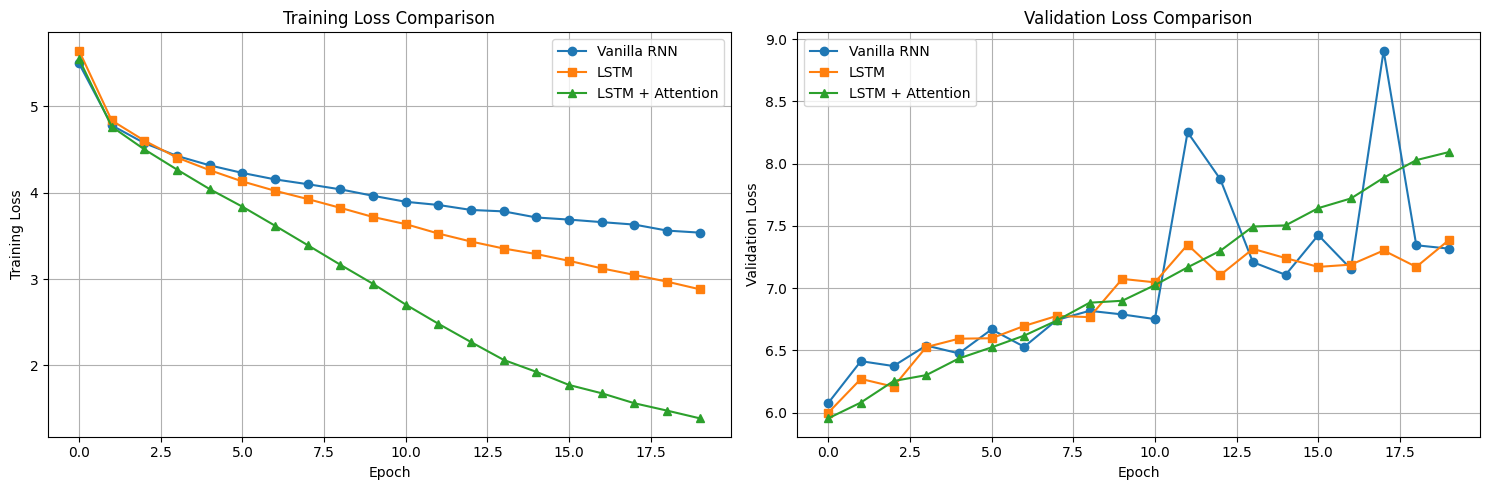

 Training curves saved to Google Drive!


In [10]:
# Cell 10: Visualizations (FIXED)
# Load training losses from saved files
with open(os.path.join(PROJECT_DIR, 'vanilla_rnn_losses.pkl'), 'rb') as f:
    rnn_losses = pickle.load(f)
    train_losses_rnn = rnn_losses['train']
    val_losses_rnn = rnn_losses['val']

with open(os.path.join(PROJECT_DIR, 'lstm_losses.pkl'), 'rb') as f:
    lstm_losses = pickle.load(f)
    train_losses_lstm = lstm_losses['train']
    val_losses_lstm = lstm_losses['val']

with open(os.path.join(PROJECT_DIR, 'lstm_attention_losses.pkl'), 'rb') as f:
    attn_losses = pickle.load(f)
    train_losses_attn = attn_losses['train']
    val_losses_attn = attn_losses['val']

print(" Training losses loaded from Google Drive!")

# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(train_losses_rnn, label='Vanilla RNN', marker='o')
axes[0].plot(train_losses_lstm, label='LSTM', marker='s')
axes[0].plot(train_losses_attn, label='LSTM + Attention', marker='^')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Training Loss Comparison')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(val_losses_rnn, label='Vanilla RNN', marker='o')
axes[1].plot(val_losses_lstm, label='LSTM', marker='s')
axes[1].plot(val_losses_attn, label='LSTM + Attention', marker='^')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Validation Loss Comparison')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_DIR, 'training_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

print(" Training curves saved to Google Drive!")


Generating attention visualizations...

--- Example 1 ---
Source: Get the hash sum of a file
Target: def get_hash ( path , form = 'sha256' , chunk_size = 65536 ) : return salt . utils . hashutils . get_hash ( os . path . expanduser ( path ) , form , chunk_size )
Predicted: def crypto_key_path_path ( self , : , : ) : return = ( ( ) ) ) )


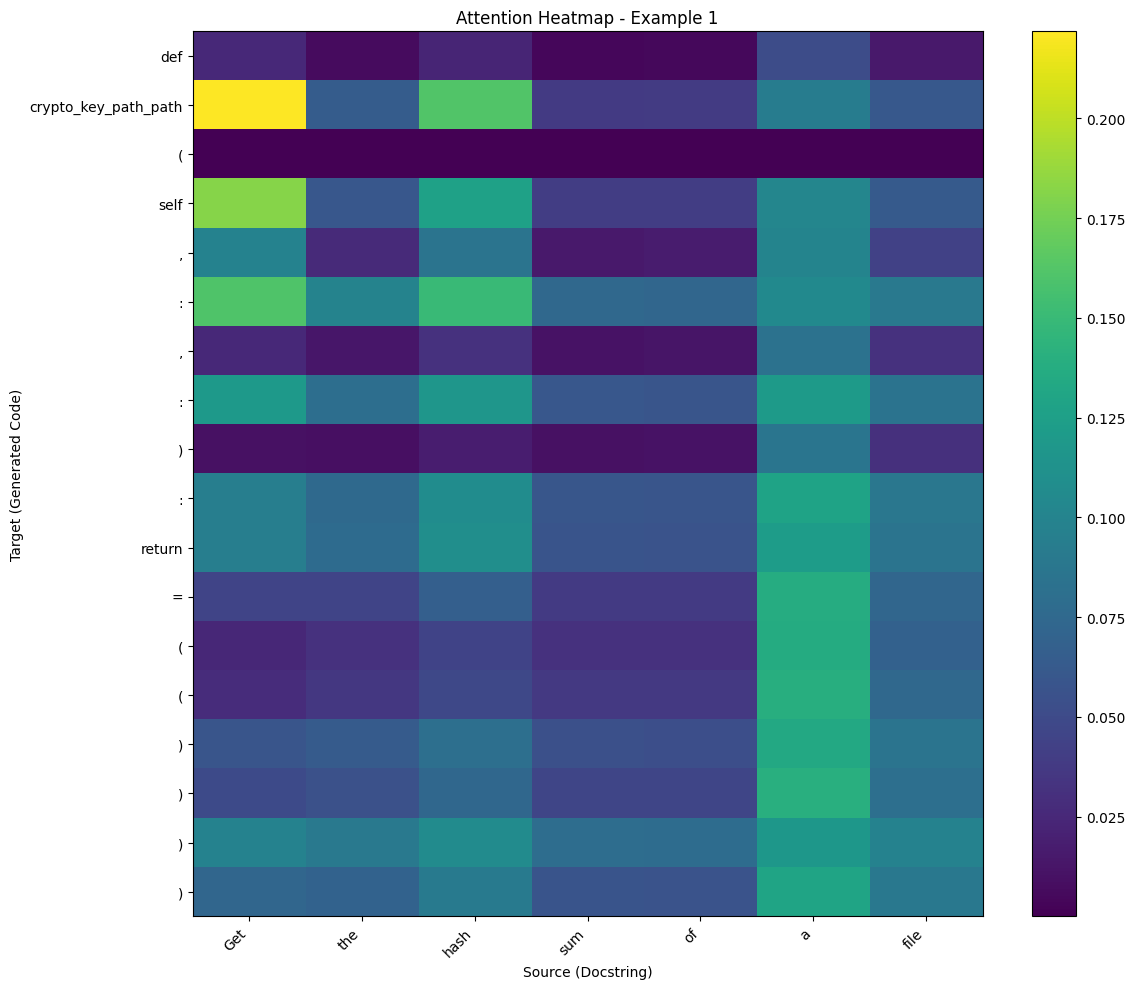


--- Example 2 ---
Source: Escape single quotes and forward slashes
Target: def _sed_esc ( string , escape_all = False ) : special_chars = "^.[$()|*+?{" string = string . replace ( "'" , "'\"'\"'" ) . replace ( "/" , "\\/" ) if escape_all is True : for char in special_chars : string = string . replace ( char , "\\" + char ) return string
Predicted: def sampling_shap_1000 ( self , : , : ) : return . . ( ( ) )


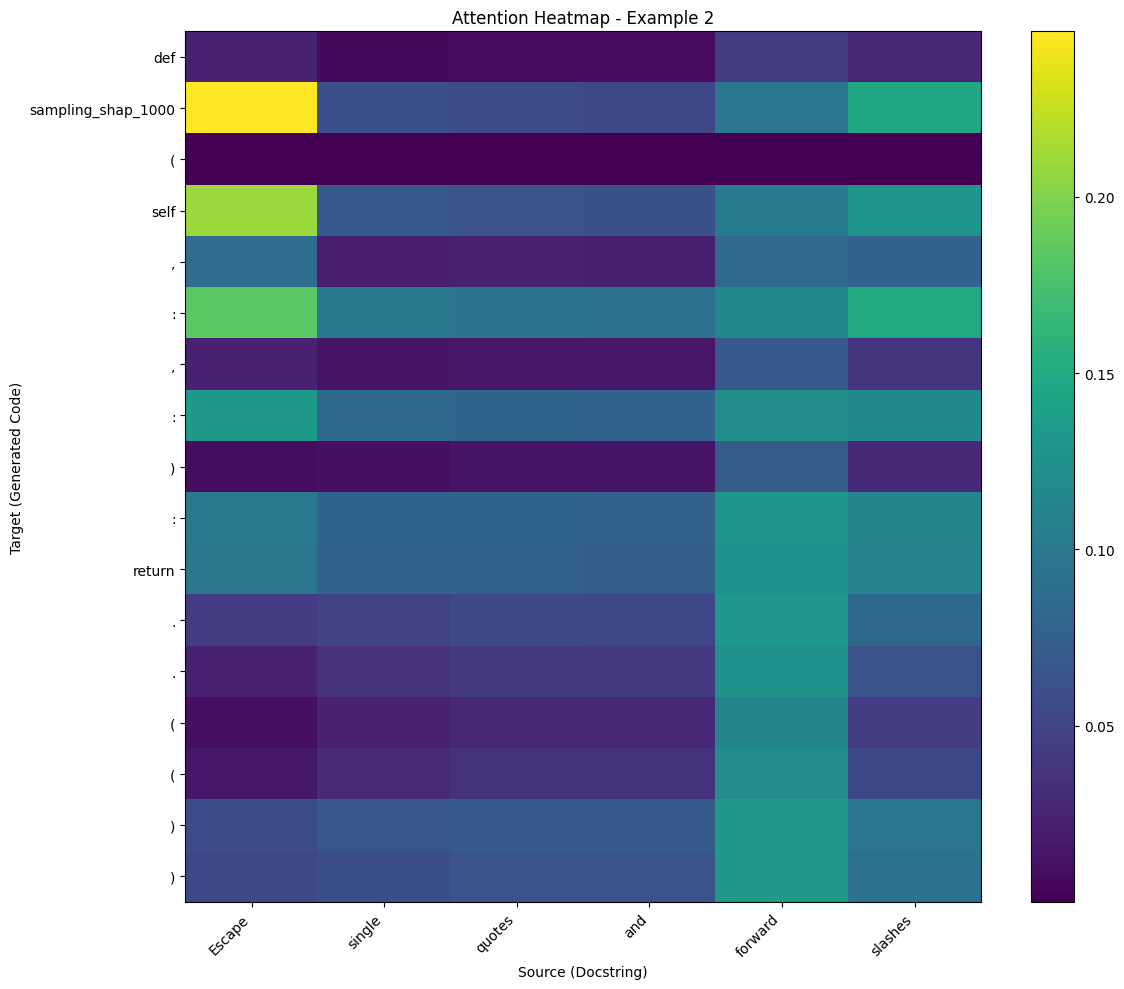


--- Example 3 ---
Source: .. deprecated :: 0 . 17 . 0 Use : py : func : ~salt . modules . file . replace instead .
Target: def uncomment ( path , regex , char = '#' , backup = '.bak' ) : return comment_line ( path = path , regex = regex , char = char , cmnt = False , backup = backup )
Predicted: def xpathNextSelf ( self , : , : ) : if = ( ) : if = . . . . ( ( ) ) ) )


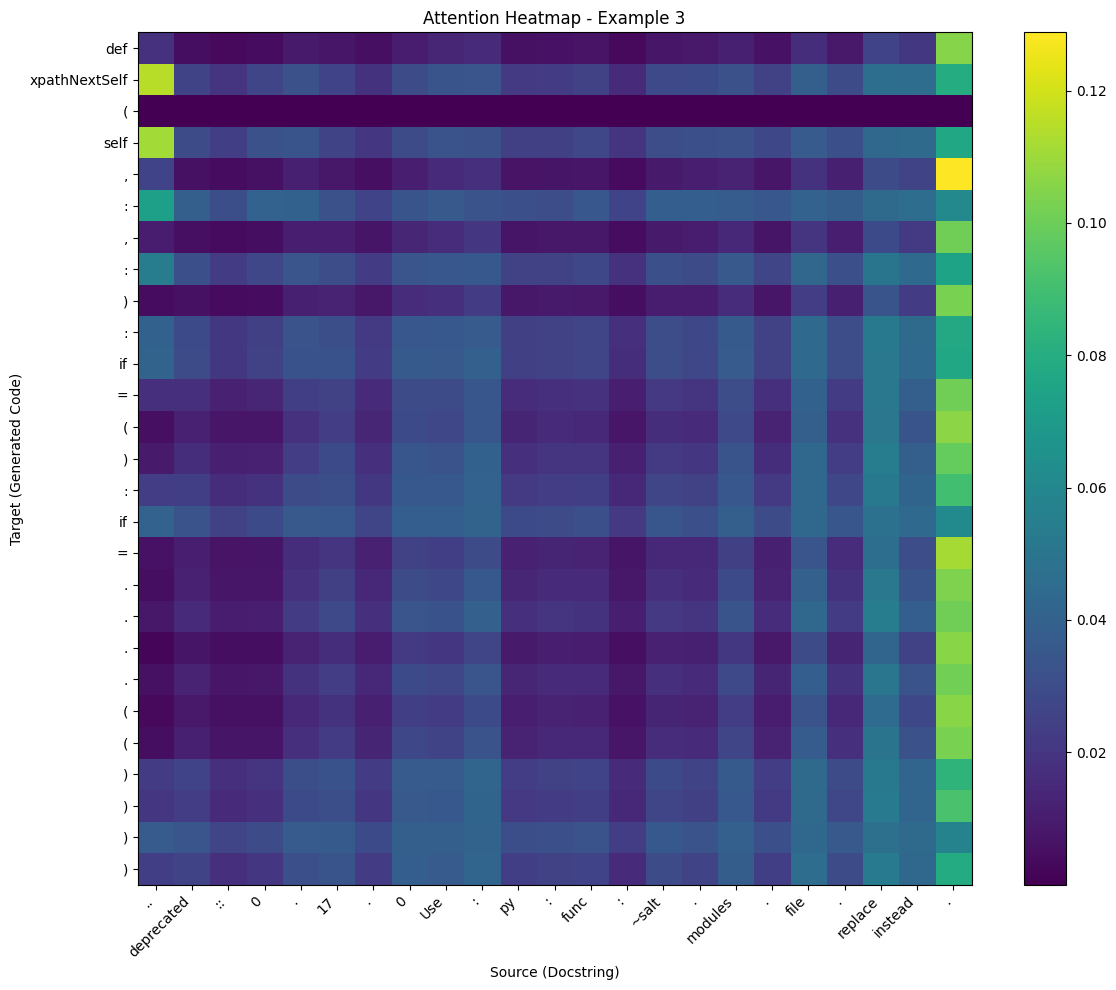


All visualizations saved to Google Drive!


In [11]:
# Cell 11: Attention Visualization
def plot_attention(src_tokens, tgt_tokens, attention_weights, example_num):
    fig, ax = plt.subplots(figsize=(12, 10))

    attention = attention_weights[:len(tgt_tokens), :len(src_tokens)]

    im = ax.imshow(attention, cmap='viridis', aspect='auto')

    ax.set_xticks(range(len(src_tokens)))
    ax.set_yticks(range(len(tgt_tokens)))
    ax.set_xticklabels(src_tokens, rotation=45, ha='right')
    ax.set_yticklabels(tgt_tokens)

    ax.set_xlabel('Source (Docstring)')
    ax.set_ylabel('Target (Generated Code)')
    ax.set_title(f'Attention Heatmap - Example {example_num}')

    plt.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.savefig(os.path.join(PROJECT_DIR, f'attention_example_{example_num}.png'), dpi=300, bbox_inches='tight')
    plt.show()

print("Generating attention visualizations...")
for i in range(3):
    example = test_data[i]
    src = example['docstring']
    tgt = example['code']

    pred_indices, attention_weights = translate_sentence(
        model_attention, src, src_vocab, tgt_vocab, device, model_type='attention')

    src_tokens = src.split()
    pred_tokens = [tgt_vocab.idx2word.get(idx, '<UNK>') for idx in pred_indices
                  if idx not in [tgt_vocab.word2idx['<PAD>'],
                                tgt_vocab.word2idx['<EOS>']]]

    print(f"\n--- Example {i+1} ---")
    print(f"Source: {src}")
    print(f"Target: {tgt}")
    print(f"Predicted: {' '.join(pred_tokens)}")

    if attention_weights is not None and len(attention_weights) > 0:
        plot_attention(src_tokens, pred_tokens, attention_weights, i+1)

print("\nAll visualizations saved to Google Drive!")


In [15]:
# Cell: Install Pygments for Beautiful Code Display
!pip install pygments -q
print(" Pygments installed!")


 Pygments installed!


In [19]:
# Cell: Beautiful Code Display with Proper Formatting
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import HtmlFormatter
from IPython.display import display, HTML
import re

def reconstruct_python_code(token_string):
    """Reconstruct Python code with proper formatting from tokens"""
    # Remove extra spaces around special characters
    code = token_string

    # Fix spacing around operators and punctuation
    code = re.sub(r'\s*\(\s*', '(', code)
    code = re.sub(r'\s*\)\s*', ')', code)
    code = re.sub(r'\s*\[\s*', '[', code)
    code = re.sub(r'\s*\]\s*', ']', code)
    code = re.sub(r'\s*\{\s*', '{', code)
    code = re.sub(r'\s*\}\s*', '}', code)
    code = re.sub(r'\s*,\s*', ', ', code)
    code = re.sub(r'\s*:\s*', ': ', code)
    code = re.sub(r'\s*=\s*', ' = ', code)
    code = re.sub(r'\s*\.\s*', '.', code)

    # Add newlines for better readability
    # After def statements
    code = re.sub(r'(def\s+\w+\s*\([^)]*\)\s*:)', r'\1\n    ', code)

    # After class statements
    code = re.sub(r'(class\s+\w+[^:]*:)', r'\1\n    ', code)

    # After if/for/while statements
    code = re.sub(r'(if\s+[^:]+:)', r'\1\n        ', code)
    code = re.sub(r'(for\s+[^:]+:)', r'\1\n        ', code)
    code = re.sub(r'(while\s+[^:]+:)', r'\1\n        ', code)

    return code.strip()

def create_beautiful_comparison(test_data, num_examples=5):
    """Create beautiful HTML comparison with properly formatted code"""

    formatter = HtmlFormatter(style='monokai', noclasses=True, linenos=False)
    css = formatter.get_style_defs('.highlight')

    html = f"""
    <style>
        {css}
        .example-container {{
            border: 2px solid #333;
            border-radius: 10px;
            margin: 25px 0;
            padding: 20px;
            background: linear-gradient(135deg, #f5f7fa 0%, #c3cfe2 100%);
        }}
        .example-title {{
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            color: white;
            padding: 15px;
            border-radius: 8px;
            font-size: 20px;
            font-weight: bold;
            margin-bottom: 20px;
            text-align: center;
        }}
        .section {{
            margin: 15px 0;
            padding: 15px;
            background: white;
            border-radius: 8px;
            box-shadow: 0 4px 6px rgba(0,0,0,0.1);
        }}
        .section-header {{
            font-weight: bold;
            font-size: 16px;
            margin-bottom: 12px;
            padding: 10px;
            border-radius: 5px;
        }}
        .input-header {{
            background: #e3f2fd;
            color: #1976d2;
        }}
        .truth-header {{
            background: #e8f5e9;
            color: #2e7d32;
        }}
        .pred-header {{
            background: #fff3e0;
            color: #e65100;
        }}
        .docstring {{
            font-style: italic;
            color: #333;
            padding: 12px;
            background: #f5f5f5;
            border-left: 4px solid #2196f3;
            font-family: 'Courier New', monospace;
            font-size: 14px;
            line-height: 1.6;
        }}
        .code-container {{
            margin: 10px 0;
            padding: 15px;
            background: #272822;
            border-radius: 5px;
            overflow-x: auto;
        }}
        .code-container pre {{
            margin: 0;
            padding: 0;
            font-family: 'Consolas', 'Monaco', monospace;
            font-size: 13px;
            line-height: 1.5;
            white-space: pre-wrap;
            word-wrap: break-word;
        }}
        .match-badge {{
            display: inline-block;
            padding: 6px 14px;
            border-radius: 20px;
            font-size: 12px;
            font-weight: bold;
            margin-left: 10px;
        }}
        .match-true {{
            background: #4caf50;
            color: white;
        }}
        .match-false {{
            background: #f44336;
            color: white;
        }}
        .model-header {{
            font-weight: bold;
            font-size: 15px;
            padding: 10px;
            margin: 15px 0 5px 0;
            border-radius: 5px;
        }}
        .model-rnn {{
            background: #fff3e0;
            color: #e65100;
        }}
        .model-lstm {{
            background: #f3e5f5;
            color: #7b1fa2;
        }}
        .model-attention {{
            background: #e0f2f1;
            color: #00695c;
        }}
    </style>
    """

    for idx in range(num_examples):
        example = test_data[idx]
        src = example['docstring']
        tgt = example['code']

        # Get predictions
        pred_rnn_indices, _ = translate_sentence(model_rnn, src, src_vocab, tgt_vocab, device, model_type='rnn')
        pred_lstm_indices, _ = translate_sentence(model_lstm, src, src_vocab, tgt_vocab, device, model_type='lstm')
        pred_attn_indices, _ = translate_sentence(model_attention, src, src_vocab, tgt_vocab, device, model_type='attention')

        pred_rnn = ' '.join([tgt_vocab.idx2word.get(i, '<UNK>') for i in pred_rnn_indices
                            if i not in [tgt_vocab.word2idx['<PAD>'], tgt_vocab.word2idx['<EOS>']]])
        pred_lstm = ' '.join([tgt_vocab.idx2word.get(i, '<UNK>') for i in pred_lstm_indices
                             if i not in [tgt_vocab.word2idx['<PAD>'], tgt_vocab.word2idx['<EOS>']]])
        pred_attn = ' '.join([tgt_vocab.idx2word.get(i, '<UNK>') for i in pred_attn_indices
                             if i not in [tgt_vocab.word2idx['<PAD>'], tgt_vocab.word2idx['<EOS>']]])

        # Reconstruct code with proper formatting
        tgt_formatted = reconstruct_python_code(tgt)
        pred_rnn_formatted = reconstruct_python_code(pred_rnn)
        pred_lstm_formatted = reconstruct_python_code(pred_lstm)
        pred_attn_formatted = reconstruct_python_code(pred_attn)

        # Syntax highlight
        tgt_html = highlight(tgt_formatted, PythonLexer(), formatter)
        pred_rnn_html = highlight(pred_rnn_formatted, PythonLexer(), formatter)
        pred_lstm_html = highlight(pred_lstm_formatted, PythonLexer(), formatter)
        pred_attn_html = highlight(pred_attn_formatted, PythonLexer(), formatter)

        # Check matches
        match_rnn = pred_rnn == tgt
        match_lstm = pred_lstm == tgt
        match_attn = pred_attn == tgt

        match_rnn_badge = f'<span class="match-badge match-true">✓ EXACT MATCH</span>' if match_rnn else '<span class="match-badge match-false">✗ DIFFERENT</span>'
        match_lstm_badge = f'<span class="match-badge match-true">✓ EXACT MATCH</span>' if match_lstm else '<span class="match-badge match-false">✗ DIFFERENT</span>'
        match_attn_badge = f'<span class="match-badge match-true">✓ EXACT MATCH</span>' if match_attn else '<span class="match-badge match-false">✗ DIFFERENT</span>'

        html += f"""
        <div class="example-container">
            <div class="example-title">📊 Example {idx + 1}</div>

            <div class="section">
                <div class="section-header input-header">📝 INPUT DOCSTRING</div>
                <div class="docstring">{src}</div>
            </div>

            <div class="section">
                <div class="section-header truth-header">✅ GROUND TRUTH</div>
                <div class="code-container">{tgt_html}</div>
            </div>

            <div class="section">
                <div class="section-header pred-header">🤖 MODEL PREDICTIONS</div>

                <div class="model-header model-rnn">
                    🟠 [1] Vanilla RNN {match_rnn_badge}
                </div>
                <div class="code-container">{pred_rnn_html}</div>

                <div class="model-header model-lstm">
                    🟣 [2] LSTM {match_lstm_badge}
                </div>
                <div class="code-container">{pred_lstm_html}</div>

                <div class="model-header model-attention">
                    🟢 [3] LSTM + Attention {match_attn_badge}
                </div>
                <div class="code-container">{pred_attn_html}</div>
            </div>
        </div>
        """

    display(HTML(html))

# Display beautiful comparison
print("Generating beautiful code comparison with proper formatting...")
create_beautiful_comparison(test_data, num_examples=5)


Generating beautiful code comparison with proper formatting...
